# Метод главных компонент (PCA) и k-ближайших соседей (kNN)
### Слуцкая Евгения Александровна, 1032206772, НПМбв-01-20

## I. Датасет:

1.  Нужно  скачать  базу  данных MNISTпри  помощи функции load_mnist из пакета mnist.py, используя код ниже:

```
from mnist import load_mnist
train, validation, test = load_mnist()
```

Получить массивы картинокв виде массива X, а также ответов labels.

2.  При  помощи  функции  matplotlib.pyplot.imshow нарисовать  несколько  примеров картинок из X. Чтобы картинки шли в виде массива, а не друг под другом, используйте функцию subplots.

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz


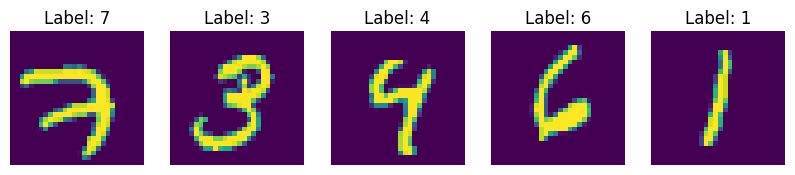

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist

# Загрузка данных MNIST
train, validation, test = load_mnist()
X, labels = train

# Отображение нескольких примеров картинок
fig, axes = plt.subplots(1, 5, figsize=(10, 10))  # 5 примеров
for i, ax in enumerate(axes):
    ax.imshow(X[i].reshape(28, 28))
    ax.set_title(f'Label: {labels[i]}')
    ax.axis('off')
plt.show()

## II. Алгоритм PCA:

Метод главных компонент состоит из следующих 4-х шагов: 

- Центрирование данных: \$X_с = X - X^-\$, где \$X^-\$ – среднее для каждого параметра
- Вычисление матрицы ковариации: \$C = X_c^TX_c\$
- Вычисление собственных векторов \$F\$ и значений \$\lambda\$ матрицы ковариации \$C\$.
- Преобразование данных в координаты в базисе главных компонент: \$Y = X_cF\$ 

1. Реализуйте описанные выше шаги 1-3 внутри метода fit(), и шаг 4 внутри метода transform() класса my_PCA. При реализации шага 3 используйте  функцию numpy.linalg.eig,  либо  реализуйте  вычисление  матрицы \$F\$ и  значений \$\lambda\$ методом сингулярного  разложения  (singular value decomposition (SVD)) матрицы \$X_с\$ без вычисления матрицы ковариации \$C\$, для чего используйте функцию numpy.linalg.svd.
2. Заметьте, что собственные значения уже упорядочены в порядке убывания. Постройте график  собственных  значений,  а  также  график  отношения  кумулятивной  суммы  к  их полной сумме. Посмотрите, какую долю дисперсии данных покрывают первые 15 главных компонент? Как связаны между собой собственные числа и дисперсия данных?
3. Изобразите на графике точки датасета в первых двух координатах главных компонент. Разным цифрам должны соответствовать разные цвета. Сделайте выводы  о  линейной разделимости классов в этих координатах.

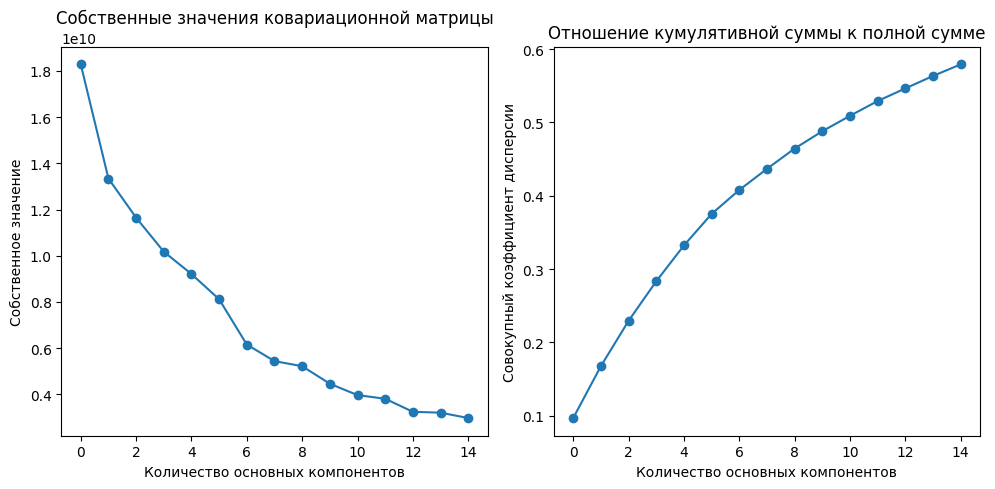

Доля дисперсии, покрываемая первыми 15 главными компонентами: 6.008977944292787


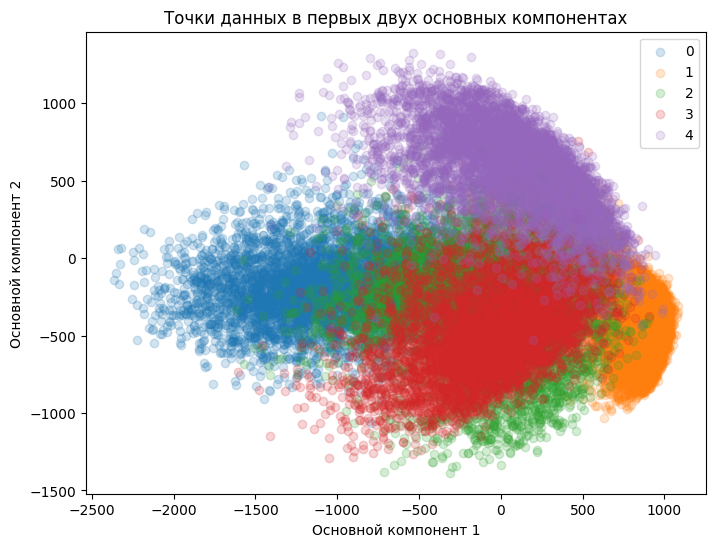

In [3]:
class my_PCA:
    def __init__(self, n_components=None):
        self.n_components = n_components

    def fit(self, X):
        X = X.reshape(X.shape[0], -1) # преобразование в 2д
        self.X_c = X - np.mean(X, axis=0)  # шаг 1
        C = np.dot(self.X_c.T, self.X_c)  # шаг 2
        lambd, F = np.linalg.eigh(C)  # шаг 3

        sorted_index = np.argsort(lambd)[::-1] # сортировка по убыванию
        self.sorted_lambd = lambd[sorted_index]
        self.sorted_F = F[:,sorted_index]

    def transform(self, X): # шаг 4
        reduced_F = self.sorted_F[:, :self.n_components]
        return np.dot(self.X_c, reduced_F)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)


pca = my_PCA(n_components=15)
X_pca = pca.fit_transform(X)

# График собственных значений
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(pca.sorted_lambd[:15], marker='o')
plt.title('Собственные значения ковариационной матрицы')
plt.xlabel('Количество основных компонентов')
plt.ylabel('Собственное значение')

# График отношения кумулятивной суммы к полной сумме
cumulative_sum = np.cumsum(pca.sorted_lambd[:15]) / np.sum(pca.sorted_lambd)
plt.subplot(1, 2, 2)
plt.plot(cumulative_sum, marker='o')
plt.title('Отношение кумулятивной суммы к полной сумме')
plt.xlabel('Количество основных компонентов')
plt.ylabel('Совокупный коэффициент дисперсии')

plt.tight_layout()
plt.show()

print("Доля дисперсии, покрываемая первыми 15 главными компонентами:", np.sum(cumulative_sum[:15]))

# Изображение точкек датасета в первых двух координатах главных компонент
plt.figure(figsize=(8, 6))
for digit in range(5):
    plt.scatter(X_pca[labels == digit, 0], X_pca[labels == digit, 1], label=str(digit), alpha=0.2)
plt.title('Точки данных в первых двух основных компонентах')
plt.xlabel('Основной компонент 1')
plt.ylabel('Основной компонент 2')
plt.legend()
plt.show()

## III. Алгоритм kNN:

Алгоритм k-ближайших соседей (k-nearest neighbours (kNN)) является одним из простейших метрических алгоритмов для решения задач классификации объектов. Суть его в следующем. Пусть у нас есть некоторая обучающая выборка данных \$X_{train}\$ с известными классами принадлежности объектов \$y_{train}\$. Предположим, есть некоторый объект \$x_*\$ с неизвестным классом, который мы хотели бы предсказать. Для этого посчитаем расстояния от \$x_*\$ до каждого из объектов \$X_{train}\$ и найдём \$k\$ ближайших (т.е. с наименьшим расстоянием) из этого набора. Поскольку мы знаем к какому классу принадлежат эти \$k\$ соседей, то мы можем предположить, что и наш объект \$x_*\$ будет принадлежать к тому классу, из которого наибольшее количество соседей. Например, пусть \$k=7\$ и среди этих семи ближайших соседей *четыре соседа оказалось в классе A, один сосед оказался в классе B и ещё два соседа оказалось в классе C*, значит мы делаем предположение, что и наш объект \$x_*\$ принадлежит классу A.

1. Реализуйте метод k-ближайших соседей в виде класса my_kNN. Заметьте, что метод init ничего не делает, кроме сохранения параметра n_neighbors во внутреннюю переменную self.n_neighbors. Аналогично метод fit лишь сохраняет переданные обучающие данные во внутренние переменные. Основные вычисления происходят лишь в методе predict, который должен возвращать предполагаемый класс.
2. Разбейте данные X и labels на обучающую и тестовую выборку, используя функцию train_test_split из модуля sklearn.model_selection.
3. Создайте классификатор my_kNN с числом соседей равным 5. Обучите классификатор на обучающих данных. Посчитайте точность на тестовой выборке, используя функцию accuracy_score из модуля sklearn.metrics. Какова точность полученного алгоритма? Если точность оказалась около 10%, значит ваш алгоритм работает как случайный, а это значит, что ваш код работает неправильно и его нужно исправить.
4. Уменьшите размерность данных с помощью реализованного выше метода главных компонент. Примените алгоритм k-ближайших соседей к преобразованным данным. Попробуйте разное количество соседей (от 1 до 30) и разное количество компонент (начиная с одной и заканчивая всеми 64). Найдите параметры, при которых алгоритм дает наибольшую точность в тестовой выборке.

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

class my_kNN:
    def __init__(self, n_neighbors):
        self.n_neighbors = n_neighbors
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
    
    def predict(self, X_test):
        y_pred = []
        for test_point in X_test:
            distances = []
            for train_point in self.X_train:
                distance = np.sqrt(np.sum((test_point - train_point)**2))
                distances.append(distance)
            nearest_indices = np.argsort(distances)[:self.n_neighbors]
            nearest_labels = self.y_train[nearest_indices]
            unique_labels, counts = np.unique(nearest_labels, return_counts=True)
            y_pred.append(unique_labels[np.argmax(counts)])
        return np.array(y_pred)


# Разбиение данных на обучающую и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=42)

# Создание и обучение классификатора my_kNN с числом соседей равным 5
knn = my_kNN(n_neighbors=5)
knn.fit(X_train[:10], y_train[:10])

# Предсказание меток для тестовой выборки
predictions = knn.predict(X_test)
print("Предсказание:", predictions)

# Оценка точности полученного алгоритма
accuracy = accuracy_score(y_test, predictions)
print("Точность алгоритма my_kNN:", accuracy)

Предсказание: [6 8 6 ... 3 2 2]
Точность алгоритма my_kNN: 0.1621212121212121
